<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/08_%5BNLP%5D_RNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: text classification with recurrent neural network**

| | |
|------|------|
| Filename | 08_[NLP]_RNN_classification.ipynb |
| Author(s) | Benjamin (contact.upside830@silomails.com) |
| Date | February 09, 2025 |
| Aim(s) | classify movie reviews with a RNN |
| Dataset(s) | IMDb Movie Reviews dataset [[1]](https://aclanthology.org/P11-1015.pdf)|
| Version | Python 3.10.12 - TensorFlow 2.17.1 - final notebook version |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. GPU execution is recommanded
3. Run all and read comments

---

#### **Motivation**

The purpose is to classify film reviews according to the sentiment expressed. The acquisition and pre-processing phases are the same as in [02_classfication_text.ipynb](https://github.com/Benjamin-morel/TensorFlow/tree/main) and [07_word2vec.ipynb](https://github.com/Benjamin-morel/TensorFlow/tree/main). The model considered is a **recurrent neural network** (RNN) with short and long memories (LSTM).

#### **Outline**

* Input section
* Python librairies & display utilities
* Data retrieval and set generation
* Model and training
* Evaluation and limitations
* Word embedding
* Conclusion
* References


---

## **0. Input section**

The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [25]:
training_phase = "No"

---

## **1. Python librairies & display utilities**

In [26]:
# @title 1.1. Python librairies [RUN ME]

"""math"""
import numpy as np # linear algebra
import sklearn.metrics # scores and evaluation metrics

"""file opening and pre-processing"""
import os # miscellaneous operating system interfaces
import pandas as pd # data manipulation tool
from re import escape # regular expressions
import string # string manipulation
import shutil # operations on files

"""ML models"""
import tensorflow as tf # framework for ML/DL
from tensorflow import keras # API used to build model in TensorFlow

"""display and export"""
import matplotlib.pyplot as plt # graphing package
from PIL import Image # image processing capabilities
import json # for data exchange format
import pickle

"""performances"""
from time import time # timer
start = time()

In [27]:
# @title 1.2. Import Github files [RUN ME]

"""clone the Github repertory TensorFlow and import model (see section 3.2)"""
def get_github_model():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata
  path_model = 'TensorFlow_duplicata/99_pre_trained_models/08_RNN_classification/08_RNN_classification.keras'
  model = keras.models.load_model(path_model)
  return model

"""clone the Github repertory TensorFlow and import files (see section 3.2)"""
def get_github_files():
  path_training_curve = 'TensorFlow_duplicata/99_pre_trained_models/08_RNN_classification/training_curves.png'
  training_curves = Image.open(path_training_curve)
  !rm -rf TensorFlow_duplicata/
  return training_curves

In [28]:
# @title 1.3. Figure plots [RUN ME]

"""plot training curves (see section 3.2)"""
def plot_evolution(history, state):

  plt.figure(figsize=(12, 5))
  if state == 'No':
    training_curves = get_github_files()
    plt.imshow(np.array(training_curves))
    plt.axis("off")
  else:
    loss_train, loss_val = history[0], history[2]
    acc_train, acc_val = history[1], history[3]
    epochs = range(1, len(acc_train) + 1)

    plt.subplot(1,2,1, title = "Loss", xlabel = "epoch", ylabel = "loss", xticks=range(len(loss_train)+1))
    plt.plot(epochs, loss_train, color = 'blue', label="training")
    plt.plot(epochs, loss_val, color = 'orange', label="validation")
    plt.legend(), plt.grid()
    plt.subplot(1,2,2, title = "Accuracy", xlabel = "epoch", ylabel="accuracy", xticks=range(len(loss_train)+1))
    plt.plot(epochs, acc_train, color = 'blue')
    plt.plot(epochs, acc_val, color = 'orange')
    plt.grid()

  plt.show()

"""plot evaluation graphs (see section 4.1)"""
def plot_evaluation(test_dataset, predictions, labels=[0,1]):
  actuals = tf.concat([y for x, y in test_dataset], axis=0)
  predicted_labels = np.round(predictions, 0)

  plt.figure(figsize=(12,5))

  confusion_mat = tf.math.confusion_matrix(actuals,predicted_labels) # columns = prediction labels / rows = real labels

  # Subplot 1: Confusion matrix
  plt.subplot(1,2,1, xlabel="Predictions", ylabel="Actuals", title="Confusion matrix of the test set", xticks=[0,1], yticks=[0,1])
  plt.imshow(confusion_mat)

  for i in range(confusion_mat.shape[0]): # annotation in each cnfusion matrix cell
      for j in range(confusion_mat.shape[1]):
          plt.text(x=j, y=i,s=int(confusion_mat[i, j]), va='center', ha='center', size='large')

  # Subplot 2: ROC curve
  fpr, tpr, _ = sklearn.metrics.roc_curve(actuals,  predictions.ravel())
  plt.subplot(1,2,2, xlabel="FPR", ylabel="TPR", title="ROC curve")
  plt.plot(fpr, tpr)

  plt.show()

  # Metrics info
  accuracy = sklearn.metrics.accuracy_score(actuals, predicted_labels)
  recall = sklearn.metrics.recall_score(actuals, predicted_labels)
  F1_score = sklearn.metrics.f1_score(actuals, predicted_labels)

  print("############################")
  print("Evaluation on the test set: ")
  print("############################")
  print("# of negative review predicted..{:.0f}" .format(confusion_mat[0,0]+confusion_mat[1,0]))
  print("# of positive review predicted..{:.0f}" .format(confusion_mat[0,1]+confusion_mat[1,1]))
  print("Accuracy........................{:.3f}" .format(accuracy))
  print("Recall..........................{:.3f}" .format(recall))
  print("F1-score........................{:.3f}" .format(F1_score))

---


## **2. Data retrieval and set generation**

### 2.1. Retrieve data

The IMDb Movie Reviews is a database created for sentiment analysis in movie reviews. It contains 50,000 movie reviews labeled with sentiment (1 for positive and 0 for negative). The database is extracted and placed in the folder `review_dataset`. The architecture of `review_dataset` is as follows:

```markdown
**review_dataset/**
. . . aclImdb/
. . . . . . train/
. . . . . . . . . pos/
. . . . . . . . . . . . *labeledBow.feat*
. . . . . . . . . . . . *pos_review_1.txt*
. . . . . . . . . . . . *pos_review_2.txt*
. . . . . . . . . . . . [...]
. . . . . . . . . neg/
. . . . . . . . . . . . *labeledBow.feat*
. . . . . . . . . . . . *neg_review_1.txt*
. . . . . . . . . . . . [...]
. . . . . . . . . unsup/
. . . . . . . . . . . . *unsup_review_1.txt*
. . . . . . . . . . . . [...]
. . . . . . test/
. . . . . . . . . pos/
. . . . . . . . . . . . *labeledBow.feat*
. . . . . . . . . . . . *pos_review_1.txt*
. . . . . . . . . . . . [...]
. . . . . . . . . neg/
. . . . . . . . . . . . [...]
. . . . . . *README*
. . . . . . *imdb.vocab*
. . . . . . *imdbEr.text*
```

Reviews with a score of 7/10 or higher are considered positive (label = 1) and reviews with a score of 4/10 or lower are considered negative (label = 0). Scores and labels are contained in the files `labeledBow.feat`.

The subfolder `unsup` contains unlabeled reviews and is deleted since it has no interest to the model.

Other files are included in the folder like `README` which provides information about the dataset and how to use it. Files `imdb.vocab` and `imdbEr.txt` contain additional information about errors, URL website and specific annotations.

In [29]:
"""extract text corpus and organize in subsets"""
def get_data(url):
  dataset_name = "Imdb_dataset_1"
  path = tf.keras.utils.get_file(dataset_name, url, extract=True)
  path = os.path.join(path, 'aclImdb')
  train_path = os.path.join(path, 'train')
  test_path = os.path.join(path, 'test')
  remove_dir = os.path.join(train_path, 'unsup') # remove the folder with unlabeled reviews for unsupervised learning
  shutil.rmtree(remove_dir)

  # data for classification model (same as 02_classification_text.ipynb)
  raw_train_ds = keras.utils.text_dataset_from_directory(train_path, batch_size=32, validation_split=0.2, subset='training', shuffle=True, seed=1, verbose=False)
  raw_val_ds = keras.utils.text_dataset_from_directory(train_path, batch_size=32, validation_split=0.2, subset='validation', shuffle=True, seed=1, verbose=False)
  raw_test_ds = keras.utils.text_dataset_from_directory(test_path, batch_size=32, verbose=False)

  return raw_train_ds, raw_val_ds, raw_test_ds

In [30]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

raw_train_ds, raw_val_ds, raw_test_ds = get_data(url)

Using 20000 files for training.
Using 5000 files for validation.


### 2.2. Pre-processing layer

Text data is pre-processed to remove punctuation (given by `string.punctuation`), html tags and upper-case letters. Then, texts are tokenized and vectorized with the keras utility `TextVectorization`. During the vectorization step, a dictionary is created to reference the most frequently used words. The number of tokens in the dictionary is set at 5,000 to capture common words and ignore rare words and names.

For each text, words referenced in the 5,000-key dictionary are converted to integers and stored in a tensor of size `max_length`. If the text has fewer words than `max_length`, the tensor is padded. It's important to define a value for `max_length` that generates few sparse matrices while retaining the maximum number of words in the text.

In the notebook [02_classfication_text.ipynb](https://github.com/Benjamin-morel/TensorFlow/tree/main), it has been shown that 90% of texts are less than 500 words long, so `max_lenght` is 500.

In [31]:
"""standardize data"""
@keras.utils.register_keras_serializable()
def custom_standardization(input_text):
  no_uppercase = tf.strings.lower(input_text) # replaces upper-case letters
  no_html_uppercase = tf.strings.regex_replace(no_uppercase, '<br />', ' ') # remove HTML tags
  no_punctuation_html_uppercase = tf.strings.regex_replace(no_html_uppercase, '[%s]' % escape(string.punctuation), '') # remove punctuation
  return no_punctuation_html_uppercase

In [32]:
max_features = 5000 # size of the dictionary
max_length = 500 # truncate to the 500th word

vectorize_layer = keras.layers.TextVectorization(standardize=custom_standardization,
                                                 max_tokens=max_features,
                                                 output_sequence_length=max_length,
                                                 output_mode='int')

vectorize_layer.adapt(raw_train_ds.map(lambda x, y: x)) # dictionary creation based on the training text corpus

In [33]:
AUTOTUNE = tf.data.AUTOTUNE # prefetch buffer size

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE) # prefetch next batch while training + fit in RAM.
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

---


## **3. Model and training**

### 3.1. Model creation

An embedding space of dimension 16 is generated in the layer `Embedding` from the 5,000 words in the dictionary. The vectors in this space are calculated during training. The output of this layer is a tensor of 500 vectors of dimension 16.

Then, a LSTM layer is used to capture dependencies in text sequences. The layer is bidirectional meaning that it processes the sequence in both directions (forward and backward) and combines the results.

A layer `Dense` is added to introduce non-linearity with the ReLu function.



In [34]:
"""define model architecture and compilation"""
def create_model():
  embedding_dim = 16
  model = keras.Sequential([vectorize_layer, # pre-processing layer
                            keras.layers.Embedding(input_dim = max_features, output_dim = embedding_dim),
                            keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
                            keras.layers.Dense(embedding_dim, activation='relu'),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(1, activation='sigmoid')], name="classification_text_model")

  model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5)])

  return model

### 3.2. Training phase

In [35]:
"""define the training configuration"""
def train_model(model, training_data, validation_data, callbacks, **kwargs):
  kwargs.setdefault("epochs", 10)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, callbacks=callbacks, **kwargs)

  return log.history["loss"], log.history["binary_accuracy"], log.history["val_loss"], log.history["val_binary_accuracy"]

In [36]:
if training_phase == "Yes":
  model = create_model()
  stop_early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True, min_delta=0.001)
  classifier_accuracy = train_model(model, raw_train_ds, raw_val_ds, callbacks = stop_early)
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), np.argmax(classifier_accuracy[3])+1))
  model.save('08_RNN_classification.keras')
else:
  model = get_github_model()
  classifier_accuracy = None

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 826, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 826 (delta 184), reused 96 (delta 96), pack-reused 583 (from 2)
Receiving objects: 100% (826/826), 190.88 MiB | 17.71 MiB/s, done.
Resolving deltas: 100% (415/415), done.


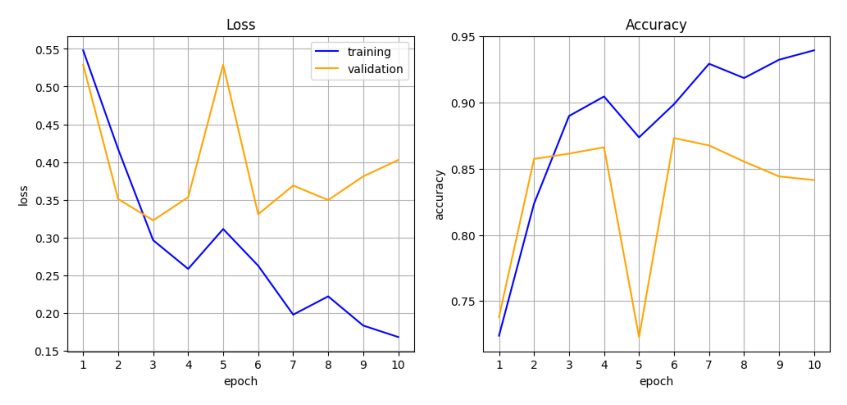

In [37]:
plot_evolution(classifier_accuracy, training_phase)

---


## **4. Evaluation and limitations**

In [38]:
"""predict test set labels and compute accuracy"""
def get_predictions(model, dataset):
  loss_test, accuracy_test = model.evaluate(dataset, verbose=0)
  predictions = model.predict(dataset, verbose=0)
  print("Test loss value %0.1f \nTest accuracy: %0.1f %%" %(loss_test, 100*accuracy_test))
  return predictions

In [39]:
predictions = get_predictions(model, raw_test_ds)

Test loss value 0.4 
Test accuracy: 86.2 %


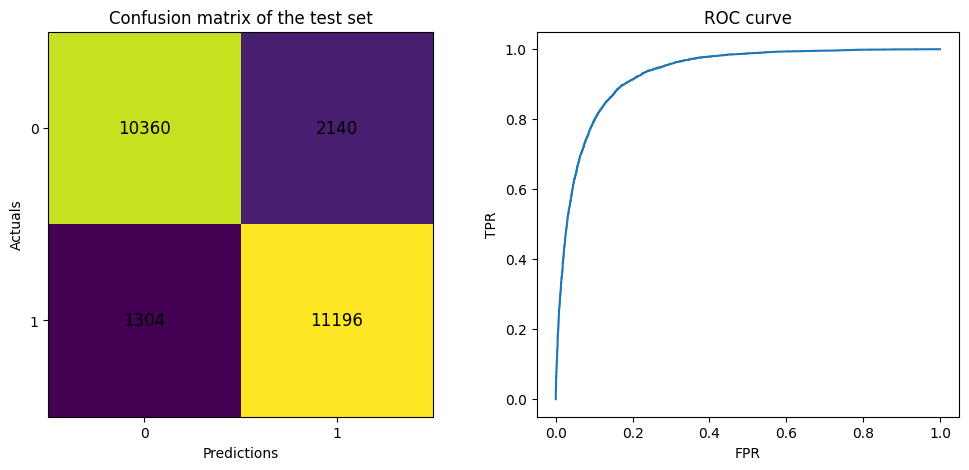

############################
Evaluation on the test set: 
############################
# of negative review predicted..11664
# of positive review predicted..13336
Accuracy........................0.862
Recall..........................0.896
F1-score........................0.867


In [40]:
plot_evaluation(raw_test_ds, predictions)

The recurrent model provides very good classification performance with an accuracy of 86%. With an f1-score of 86%, the model classifies both positive and negative reviews.

---


## **5. Embedding word**

### 5.1. Embedding dictionary

In [41]:
"""generate an embedding word-vector dictionary """
def build_embedding_dict(model):
  embeddings_vector = model.layers[1].get_weights()[0] # get all 5,000 vectors of the embedding layer
  vocab = vectorize_layer.get_vocabulary() # get get all 5,000 most frequent words
  dictionary = {vocab[i]:embeddings_vector[i] for i in range(max_features)}
  print("Dictionary shape: ", np.shape(embeddings_vector))

  with open('08_classification_text_RNN_dict.json', 'w') as f: # save dictionary in JSON format
    modified_dict = {k: v.tolist() for k, v in dictionary.items()}
    json.dump(modified_dict, f)

  return dictionary, vocab

In [42]:
my_dict, all_words = build_embedding_dict(model)

Dictionary shape:  (5000, 16)


### 5.2. Distance and similarity

In [43]:
"""get the distance between two elements in the embedding space"""
def get_distance(token1, token2):
  p1 = my_dict[token1]
  p2 = my_dict[token2]
  distance = np.linalg.norm(p2-p1)
  return distance

"""get the cosinus similarity between two elements in the embedding space"""
def get_cosinus_similarity(token1, token2):
  p1 = my_dict[token1]
  p2 = my_dict[token2]
  dot_product = np.dot(p1, p2)
  magnitude_1 = np.linalg.norm(p1)
  magnitude_2 = np.linalg.norm(p2)
  cosine_sim = dot_product / (magnitude_1 * magnitude_2)
  return cosine_sim

In [44]:
"""get elements closest to a specific element in the embedding space"""
def get_synomym(token, n=10, used_distance=True):
  p1 = my_dict[token]
  candidate_list = {} # stores n synonyms
  for i in range(1, max_features):
    token_candidate = all_words[i]
    if used_distance == True: candidate_list[token_candidate] = get_distance(token, token_candidate)
    else: candidate_list[token_candidate] = get_cosinus_similarity(token, token_candidate)

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])

  if used_distance == True: synonym_list = sorted_items[1:n+1]
  else: synonym_list = sorted_items[-(n+1):-1]
  words = [(item[0], item[1]) for item in synonym_list]
  return print(words)

In [45]:
get_synomym("terrible", used_distance=False)

[('devoid', 0.9911029), ('disappointed', 0.99114496), ('lame', 0.991471), ('alright', 0.99155796), ('disappointing', 0.9916821), ('lacks', 0.99194723), ('uninteresting', 0.9921935), ('wasting', 0.9927402), ('struggling', 0.99301857), ('embarrassment', 0.9934863)]


In [46]:
"""get elements found with an analogy"""
def get_analogy(vector, n):
  candidate_list = {}
  for i in range(1, max_features):
    token_candidate = all_words[i]
    vector_candidate = my_dict[token_candidate]
    candidate_list[token_candidate] = sum(abs(vector - vector_candidate))

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])
  synonym_list = sorted_items[0:n]
  words = [item[0] for item in synonym_list]
  return print(words)

In [47]:
analogy = my_dict["funny"] - my_dict["nice"] + my_dict["terrible"]
get_analogy(analogy, 5)

['lacks', 'disappointing', 'unfunny', 'unconvincing', '310']


Overview from projector (https://projector.tensorflow.org/?hl=fr)

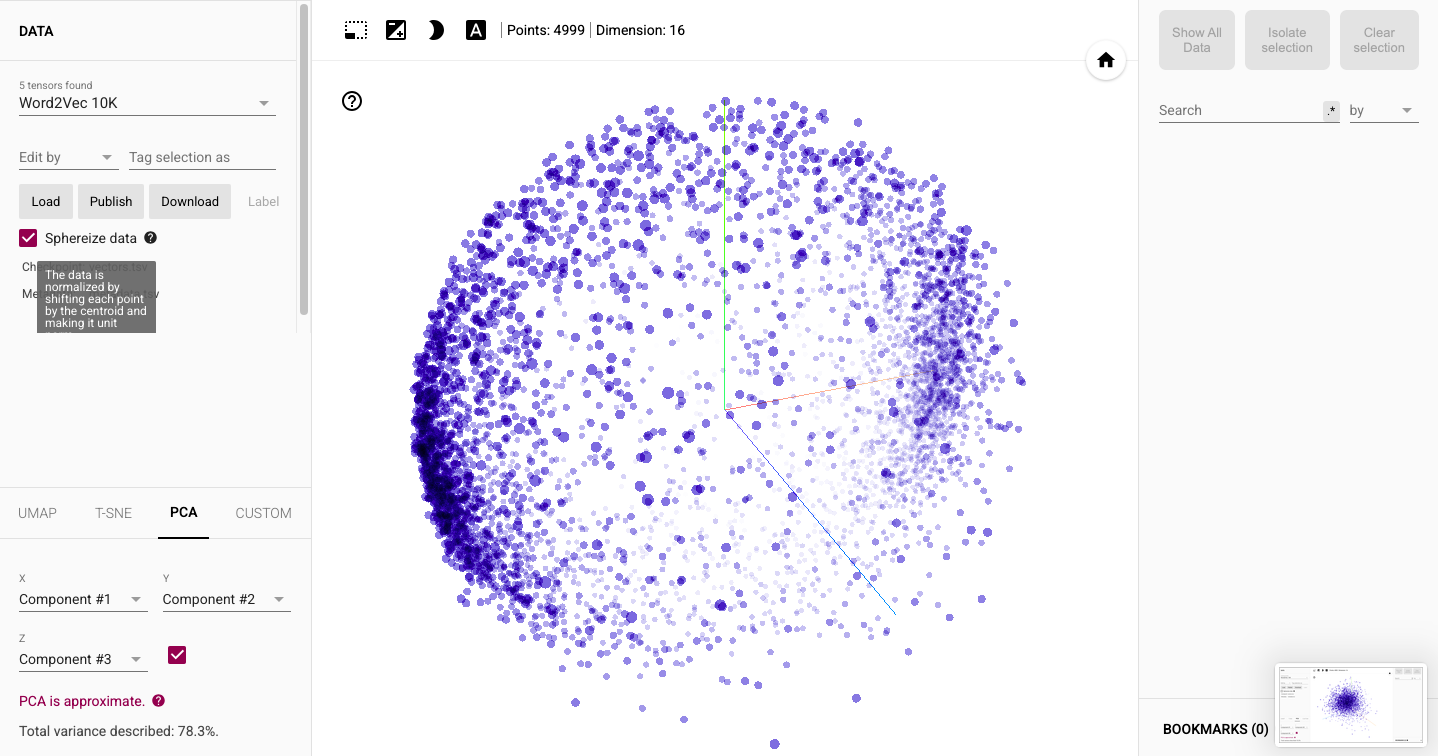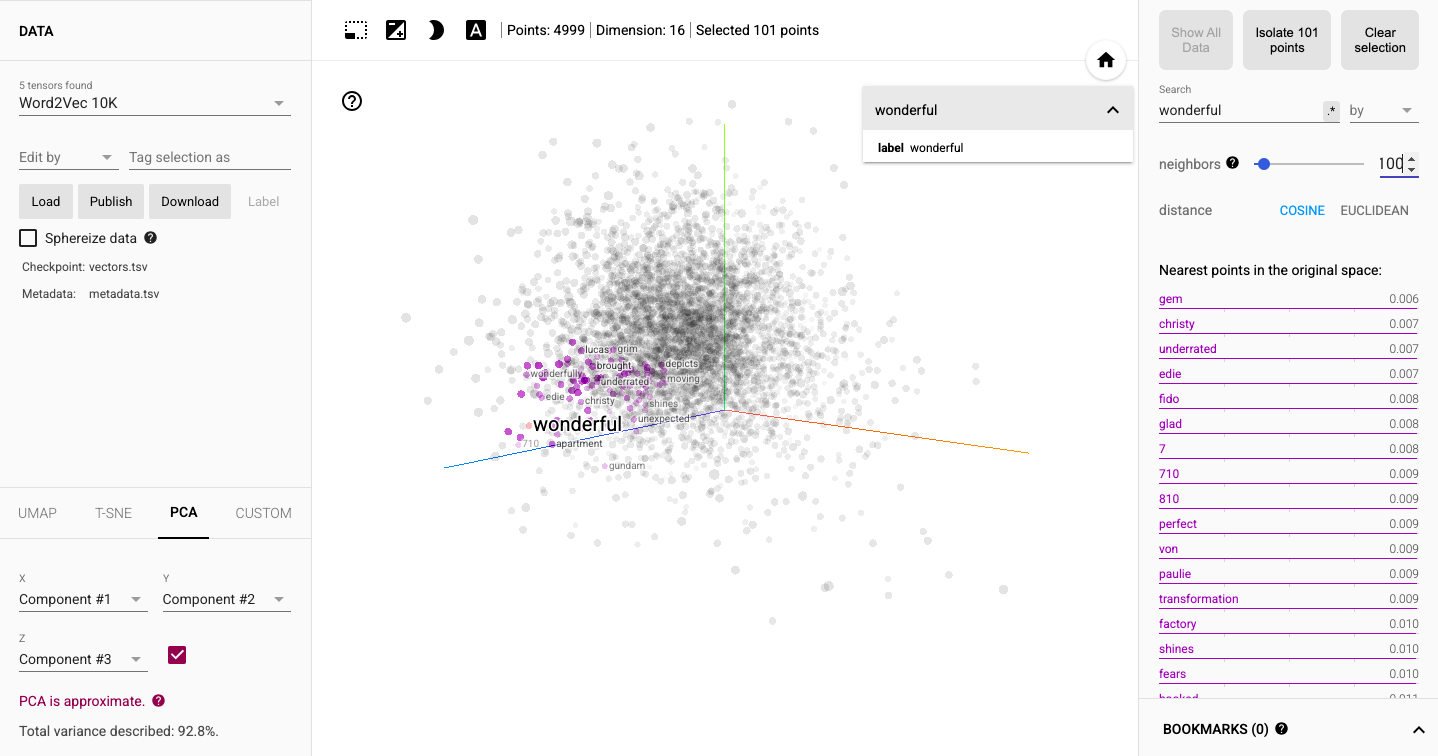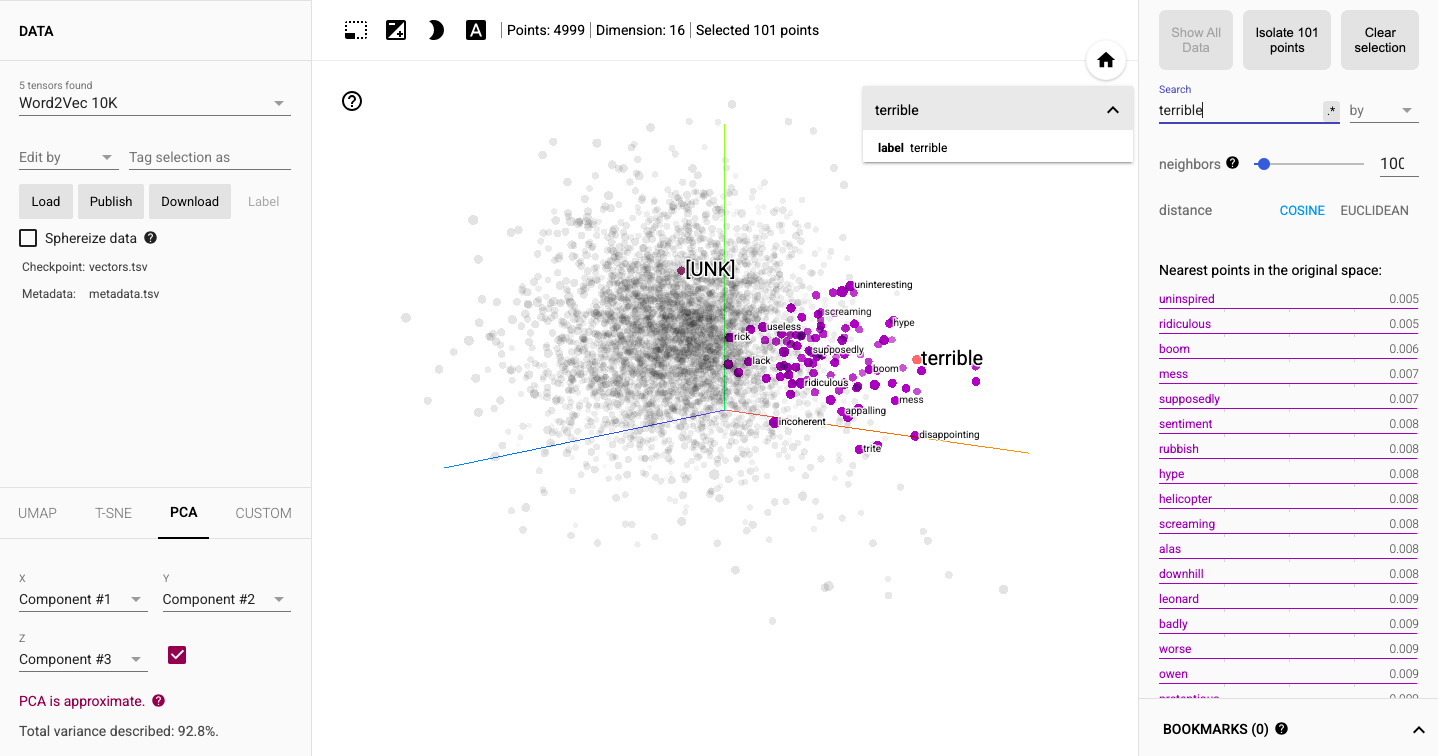

---


## **6. Conclusion**

The model developed achieves a satisfactory level of accuracy for sentiment classification. The following notebook compares the predictions and performance of this model with other classification models developed previously.  


---


## **7. References**

| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://aclanthology.org/P11-1015.pdf) | IMDB dataset | Andrew L. Maas & al | dataset & paper | - |
|[[2]](https://www.tensorflow.org/text/tutorials/text_classification_rnn) | Text classification with an RNN | TensorFlow | tutoriels | - |
|[[3]](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) | Understanding LSTM Networks | Colah | lecture | - |

In [48]:
print("Notebook run in %.1f seconds on %s" % ((time() - start), tf.config.list_physical_devices(device_type=None)[-1][-1]))

Notebook run in 201.9 seconds on CPU
